In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def load_binary_mnist(selected_classes=[0, 1], img_size=32):
    """
    Loads and preprocesses the Binary MNIST dataset.

    Args:
        selected_classes (list): List of classes to include (e.g., [0, 1]).
        img_size (int): Desired image size after resizing.

    Returns:
        tuple: Preprocessed training and test datasets.
    """
    # Load MNIST data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # Filter the data to include only selected classes
    train_filter = np.isin(y_train, selected_classes)
    test_filter = np.isin(y_test, selected_classes)

    x_train, y_train = x_train[train_filter], y_train[train_filter]
    x_test, y_test = x_test[test_filter], y_test[test_filter]

    # Relabel the classes to 0 and 1
    class_to_idx = {cls: idx for idx, cls in enumerate(selected_classes)}
    y_train = np.vectorize(class_to_idx.get)(y_train)
    y_test = np.vectorize(class_to_idx.get)(y_test)

    # Expand dimensions to include channel information
    x_train = np.expand_dims(x_train, axis=-1)
    x_test = np.expand_dims(x_test, axis=-1)

    # Resize images to img_size x img_size
    x_train = tf.image.resize(x_train, [img_size, img_size]).numpy()
    x_test = tf.image.resize(x_test, [img_size, img_size]).numpy()

    # Normalize the images to [0, 1]
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.

    # One-hot encode the labels
    y_train = to_categorical(y_train, num_classes=2)
    y_test = to_categorical(y_test, num_classes=2)

    return (x_train, y_train), (x_test, y_test)

In [4]:
def build_nin_model(input_shape=(32, 32, 1), num_classes=2):
    """
    Builds the Network in Network (NiN) model.

    Args:
        input_shape (tuple): Shape of the input images.
        num_classes (int): Number of output classes.

    Returns:
        tf.keras.Model: Compiled NiN model.
    """
    weight_decay = 5e-4  # L2 regularization factor

    model = models.Sequential()

    # First MLPConv layer
    model.add(layers.Conv2D(64, kernel_size=5, padding='same', input_shape=input_shape,
                            kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(64, kernel_size=1, padding='same',
                            kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(64, kernel_size=1, padding='same',
                            kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=3, strides=2, padding='same'))
    model.add(layers.Dropout(0.25))

    # Second MLPConv layer
    model.add(layers.Conv2D(192, kernel_size=5, padding='same',
                            kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(192, kernel_size=1, padding='same',
                            kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(192, kernel_size=1, padding='same',
                            kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=3, strides=2, padding='same'))
    model.add(layers.Dropout(0.25))

    # Third MLPConv layer
    model.add(layers.Conv2D(192, kernel_size=3, padding='same',
                            kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(192, kernel_size=1, padding='same',
                            kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(num_classes, kernel_size=1, padding='same',
                            kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Flatten())
    model.add(layers.Activation('softmax'))

    model.summary()
    
    return model

In [5]:
def compile_and_train(model, train_data, test_data, epochs=20, batch_size=128):
    """
    Compiles and trains the NiN model.

    Args:
        model (tf.keras.Model): The NiN model.
        train_data (tuple): Tuple of training data (x_train, y_train).
        test_data (tuple): Tuple of test data (x_test, y_test).
        epochs (int): Number of training epochs.
        batch_size (int): Size of training batches.

    Returns:
        history: Training history object.
    """
    model.compile(optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_data[0], train_data[1],
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=test_data,
                        shuffle=True)

    return history

In [6]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Args:
        history: Training history object.
    """
    # Plot Loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

c:\Users\nguye\anaconda3\envs\ai\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 192)    │       307,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 192)    │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 16, 16, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 192)    │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 16, 16, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 192)      │       331,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 192)      │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 2)        │           386 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 8, 8, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 760,898 (2.90 MB)

 Trainable params: 760,898 (2.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 32s 307ms/step - accuracy: 0.6320 - loss: 1.1560 - val_accuracy: 0.9362 - val_loss: 0.7216
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 29s 297ms/step - accuracy: 0.9601 - loss: 0.6192 - val_accuracy: 0.9934 - val_loss: 0.5153
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 30s 306ms/step - accuracy: 0.9888 - loss: 0.5223 - val_accuracy: 0.9943 - val_loss: 0.5007
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 31s 314ms/step - accuracy: 0.9908 - loss: 0.5011 - val_accuracy: 0.9986 - val_loss: 0.4780
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 28s 285ms/step - accuracy: 0.9937 - loss: 0.4863 - val_accuracy: 0.9981 - val_loss: 0.4695
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 29s 289ms/step - accuracy: 0.9960 - loss: 0.4699 - val_accuracy: 0.9986 - val_loss: 0.4571
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 28s 288ms/step - accuracy: 0.9944 - loss: 0.4683 - val_accuracy: 0.9986 - val_loss: 0.4486
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 28s 288ms/step - accuracy: 0.9975 - loss: 0.4492 - val_accu

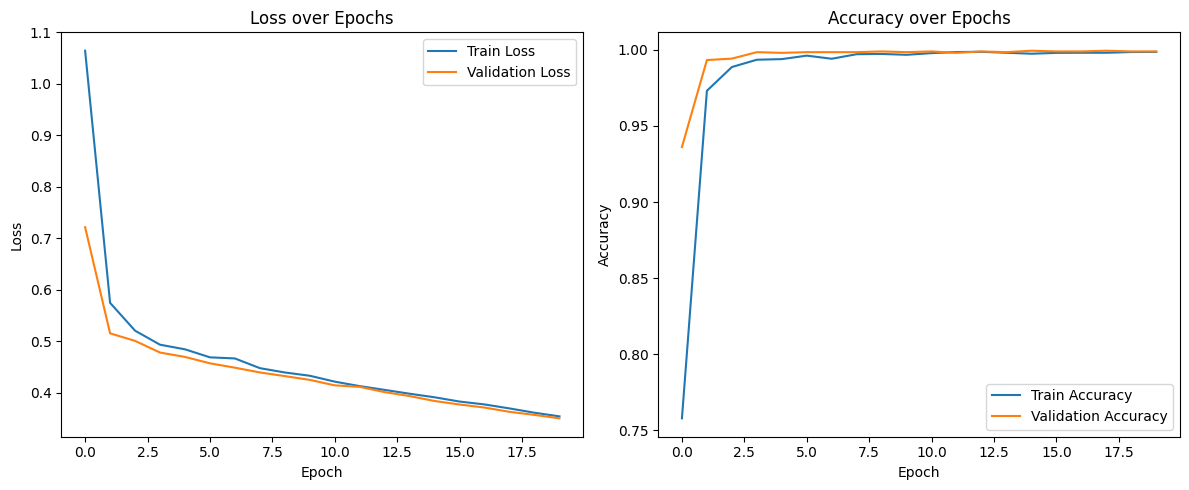

In [7]:
# Hyperparameters
batch_size = 128
epochs = 20
# Load and preprocess data
(x_train, y_train), (x_test, y_test) = load_binary_mnist(selected_classes=[0, 1], img_size=32)
# Build the NiN model
model = build_nin_model(input_shape=(32, 32, 1), num_classes=2)
# Compile and train the model
history = compile_and_train(model, (x_train, y_train), (x_test, y_test),
                            epochs=epochs, batch_size=batch_size)
# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.2f}%')
# Plot training history
plot_training_history(history)